In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [3]:
df = pd.read_csv(r"C:\Users\arpit\destop\IMDb Movies India.csv", encoding="latin1")
print("Data Shape:", df.shape)
print(df.head())

Data Shape: (15509, 10)
                                 Name    Year Duration            Genre  \
0                                         NaN      NaN            Drama   
1  #Gadhvi (He thought he was Gandhi)  (2019)  109 min            Drama   
2                         #Homecoming  (2021)   90 min   Drama, Musical   
3                             #Yaaram  (2019)  110 min  Comedy, Romance   
4                   ...And Once Again  (2010)  105 min            Drama   

   Rating Votes            Director       Actor 1             Actor 2  \
0     NaN   NaN       J.S. Randhawa      Manmauji              Birbal   
1     7.0     8       Gaurav Bakshi  Rasika Dugal      Vivek Ghamande   
2     NaN   NaN  Soumyajit Majumdar  Sayani Gupta   Plabita Borthakur   
3     4.4    35          Ovais Khan       Prateik          Ishita Raj   
4     NaN   NaN        Amol Palekar  Rajat Kapoor  Rituparna Sengupta   

           Actor 3  
0  Rajendra Bhatia  
1    Arvind Jangid  
2       Roy Angana  
3 

In [4]:
# Data Cleaning
# Drop rows with missing Rating
df = df.dropna(subset=["Rating"])
# Clean 'Year' column: remove brackets and convert to int
df["Year"] = df["Year"].str.extract(r"(\d{4})").astype(float)
# Clean 'Duration' column: remove "min"
df["Duration"] = df["Duration"].str.replace("min", "", regex=False).astype(float)
# Fill missing values
df["Votes"] = pd.to_numeric(df["Votes"], errors="coerce")
df["Votes"] = df["Votes"].fillna(df["Votes"].median())
# Drop Name
df = df.drop(columns=["Name"])

print("Cleaned Data Shape:", df.shape)

Cleaned Data Shape: (7919, 9)


In [5]:
#  Features & Target

X = df.drop("Rating", axis=1)
y = df["Rating"]

# Separate categorical and numeric columns
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

print("Numeric Features:", num_cols.tolist())
print("Categorical Features:", cat_cols.tolist())


Numeric Features: ['Year', 'Duration', 'Votes']
Categorical Features: ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']


In [6]:
# Preprocessing
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),("encoder", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, num_cols), ("cat", categorical_transformer, cat_cols)])

In [8]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [9]:
# Evaluation
print("Model Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Model Performance:
MAE: 0.8697734762734042
MSE: 1.2811906842224103
R² Score: 0.3108710792856012


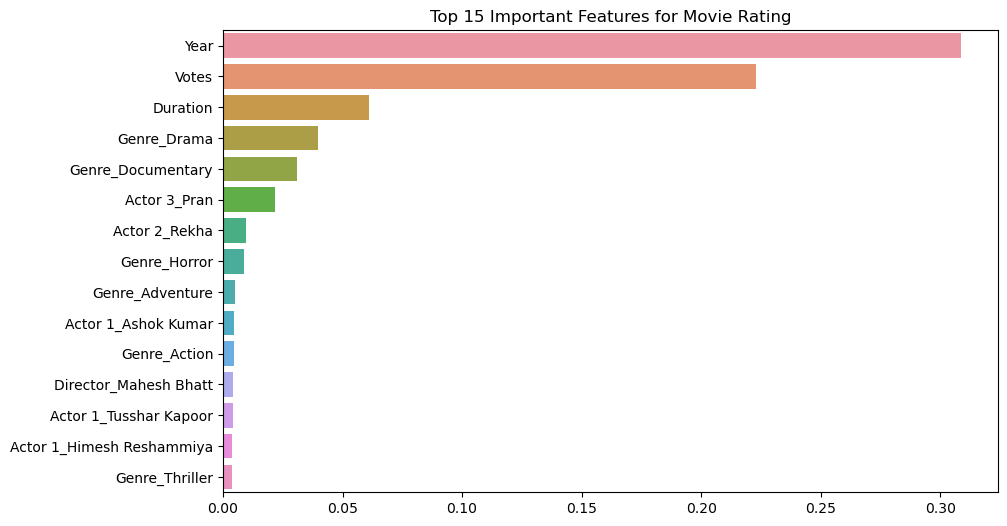

In [10]:
# Feature Importance (Optional)
# Get feature names after one-hot encoding
cat_features = model.named_steps["preprocessor"].transformers_[1][1] \
    .named_steps["encoder"].get_feature_names_out(cat_cols)

feature_names = np.concatenate([num_cols, cat_features])
importances = model.named_steps["model"].feature_importances_
# features
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:15]
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Top 15 Important Features for Movie Rating")
plt.show()